In [1]:
# Import necessary libraries
import requests     # For making HTTP requests to the API
import numpy as np  # For numerical operations
import matplotlib.pyplot as plt  # For plotting
from mpl_toolkits.basemap import Basemap   # For creating maps (Note: Basemap needs numpy < v2, e.g., numpy==1.26.4)
import matplotlib.colors as mcolors        # For color mapping
from scipy.interpolate import griddata     # For interpolating data onto a grid
from scipy.ndimage import gaussian_filter  # For smoothing data
import gsw  # TEOS-10 Gibbs Seawater library for oceanographic calculations
from dataclasses import dataclass     # For creating data classes
from typing import Tuple, List, Dict  # For type hinting
import numpy.typing as npt            # For NumPy type hinting

In [2]:
# (Commented out) Original function placeholder for calculating sea density
# This calculation is now integrated into the process_section_data function using the gsw library.
# def calculate_sea_density(temp, sal, pressure, lon, lat):
"""
#     Calculate potential density anomaly (σθ) using TEOS-10 GSW-Python library.
# 
#     Parameters:
#     - temp: Conservative Temperature (θ in °C).
#     - sal: Practical Salinity (SP).
#     - pressure: Pressure (dbar).
#     - lon: Longitude (°E).
#     - lat: Latitude (°N).
# 
#     Returns:
#     - Potential density anomaly (σθ in kg/m^3).
"""
#    SA = gsw.SA_from_SP(sal, pressure, lon, lat)  # Absolute Salinity (g/kg)
#    CT = gsw.CT_from_t(SA, temp, pressure)  # Conservative Temperature (°C)
#    sigma_theta = gsw.sigma0(SA, CT)  # Potential Density Anomaly (kg/m^3)
#    return sigma_theta

# Function to fetch data from the ODB WOA23 API
def fetch_woa23_data(lon0, lat0, lon1, lat1, dep0, dep1):
    """Fetches oceanographic data (temperature, salinity, oxygen) from the WOA23 API
    for a specified geographic region and depth range.

    Args:
        lon0 (float): Starting longitude.
        lat0 (float): Starting latitude.
        lon1 (float): Ending longitude.
        lat1 (float): Ending latitude.
        dep0 (int): Starting depth (dbar).
        dep1 (int): Ending depth (dbar).

    Returns:
        dict: A dictionary containing the fetched data in JSON format.
    """
    # Base URL of the ODB WOA23 API
    base_url = "https://eco.odb.ntu.edu.tw/api/woa23"
    
    # Parameters for the API request
    params = {
        "lon0": lon0,  # Longitude start
        "lat0": lat0,  # Latitude start
        "lon1": lon1,  # Longitude end
        "lat1": lat1,  # Latitude end
        "dep0": dep0,  # Depth start
        "dep1": dep1,  # Depth end
        "parameter": "temperature,salinity,oxygen",  # Parameters to fetch
        "time_period": 0,  # Time period (0 for annual average)
        "append": "an",    # 'an' means Objectively analyzed climatology in WOA23 data. See: https://odv.awi.de/fileadmin/user_upload/odv/data/WOA23/woa23documentation.pdf
        "grid": 1,  # Grid resolution (1 for 1-degree grid)
    }
    
    # Send GET request to the API, and return the response data as JSON
    response = requests.get(base_url, params=params)
    return response.json()


In [3]:
# Reference for data structure/visualization: https://essd.copernicus.org/articles/15/4481/2023/ Fig.4

# Define a dataclass to hold the processed ocean data arrays
@dataclass
class OceanData:
    """A data class to store oceanographic data arrays."""
    lons: npt.NDArray      # Longitudes
    lats: npt.NDArray      # Latitudes
    depths: npt.NDArray    # Depths (pressure in dbar)
    temps: npt.NDArray     # Temperatures (°C)
    sals: npt.NDArray      # Salinities (Practical Salinity)
    oxys: npt.NDArray      # Dissolved Oxygen (µmol/kg)
    densities: npt.NDArray # Potential Density Anomaly (σθ in kg/m³)

# Function to process the raw data fetched from the API
def process_section_data(data: List[Dict]) -> OceanData:
    """Processes the raw list of dictionaries from the API into structured NumPy arrays,
    calculates potential density anomaly, and returns an OceanData object.
    Uses vectorized operations for improved performance.

    Args:
        data (List[Dict]): Raw data fetched from the WOA23 API.

    Returns:
        OceanData: An object containing NumPy arrays of lons, lats, depths, temps, sals, oxys, and densities.
    """
    # Filter out entries with missing essential data (oxygen, temperature, salinity)
    valid_data = [
        entry for entry in data
        if all(entry[key] is not None for key in ['oxygen_an', 'temperature_an', 'salinity_an'])
    ]
    
    arr = np.array([
        (entry['lon'], entry['lat'], entry['depth'],
         entry['temperature_an'], entry['salinity_an'], entry['oxygen_an'])
        for entry in valid_data
    ], dtype=[('lon', float), ('lat', float), ('depth', float),
              ('temp', float), ('sal', float), ('oxy', float)])
    
    # Vectorized calculation of Absolute Salinity (SA) and Conservative Temperature (CT) using GSW library
    # Note: Using pressure (depth in dbar) as an approximation for pressure calculations in GSW.
    sa = gsw.SA_from_SP(arr['sal'], arr['depth'], arr['lon'], arr['lat']) # Absolute Salinity (g/kg)
    ct = gsw.CT_from_t(sa, arr['temp'], arr['depth']) # Conservative Temperature (°C)
    
    # Calculate Potential Density Anomaly (sigma0) using the calculated SA and CT
    density = gsw.sigma0(sa, ct) # Potential Density Anomaly (kg/m³)
    
    # Return the processed data stored in an OceanData object
    return OceanData(
        arr['lon'], arr['lat'], arr['depth'],
        arr['temp'], arr['sal'], arr['oxy'], density
    )

# Function to prepare gridded data for plotting using interpolation
def prepare_grid_data(ocean_data: OceanData, section_type: str = 'vertical') -> Tuple:
    """Prepares interpolated grid data for either vertical or horizontal sections.

    Args:
        ocean_data (OceanData): Processed ocean data.
        section_type (str, optional): Type of section ('vertical' or 'horizontal'). 
                                      Defaults to 'vertical'.

    Returns:
        Tuple: A tuple containing the grid coordinates (lat/lon, depth/lat) and the 
               interpolated oxygen grid. For vertical sections, also returns the 
               interpolated density grid.
    """
    if section_type == 'vertical':
        # Prepare grid for vertical sections (latitude vs. depth)
        # Get unique latitude and depth values from the data
        lat_unique = np.unique(ocean_data.lats)
        depth_unique = np.unique(ocean_data.depths)
        
        # Create a meshgrid for interpolation
        lat_grid, depth_grid = np.meshgrid(lat_unique, depth_unique)
        
        # Define the points where data exists (latitude, depth pairs)
        points = np.column_stack((ocean_data.lats, ocean_data.depths))
        
        # Interpolate oxygen data onto the grid using cubic interpolation
        oxy_grid = griddata(points, ocean_data.oxys, (lat_grid, depth_grid), method='cubic')
        
        # Interpolate density data onto the grid using cubic interpolation
        density_grid = griddata(points, ocean_data.densities, (lat_grid, depth_grid), method='cubic')
        
        # Return the grids for latitude, depth, oxygen, and density
        return lat_grid, depth_grid, oxy_grid, density_grid
    else:
        # Prepare grid for horizontal sections (longitude vs. latitude)
        # Create linearly spaced longitude and latitude arrays for the grid
        lon_unique = np.linspace(np.min(ocean_data.lons), np.max(ocean_data.lons), 360) # 360 points for longitude
        lat_unique = np.linspace(np.min(ocean_data.lats), np.max(ocean_data.lats), 180) # 180 points for latitude
        
        # Create a meshgrid for interpolation
        lon_grid, lat_grid = np.meshgrid(lon_unique, lat_unique)
        
        # Define the points where data exists (longitude, latitude pairs), and then interpolate oxygen data onto the grid 
        points = np.column_stack((ocean_data.lons, ocean_data.lats))
        oxy_grid = griddata(points, ocean_data.oxys, (lon_grid, lat_grid), method='cubic')
        
        return lon_grid, lat_grid, oxy_grid

In [4]:
# Fetch map data for 300 dbar
map_data = fetch_woa23_data(-179.9, -89.9, 179.9, 89.9, 300, 300)

In [5]:
# Fetch data for Pacific, Indian, and Atlantic oceans (surface to 2000 dbar)
pacific_data = fetch_woa23_data(-179.9, -60, -70, 60, 0, 2000)


In [6]:
indian_data = fetch_woa23_data(30, -60, 120, 30, 0, 2000)


In [7]:
atlantic_data = fetch_woa23_data(-70, -60, 20, 60, 0, 2000)


In [8]:
# Process all data once
processed_data = {
    'map': process_section_data(map_data),
    'pacific': process_section_data(pacific_data),
    'indian': process_section_data(indian_data),
    'atlantic': process_section_data(atlantic_data)
}

In [9]:
def plot_ocean_sections(processed_data: Dict[str, OceanData]):
    """Plot ocean sections with improved visualization and land masking."""
    fig = plt.figure(figsize=(16, 10))
    gs = plt.GridSpec(2, 2, height_ratios=[1, 1], width_ratios=[1, 1], wspace=0.2, hspace=0.3)

    # Create custom colormap with better gradient
    colors = plt.cm.Blues_r(np.linspace(0, 1, 256))
    colors = np.vstack((colors[0:1], colors))
    custom_cmap = mcolors.LinearSegmentedColormap.from_list('custom_Blues_r', colors)
    
    # Shared color limits
    vmin, vmax = 0, 350
    levels = np.linspace(vmin, vmax, 15)
    density_levels = np.arange(26, 28, 0.25)

    # Plot map
    ax_map = fig.add_subplot(gs[0, 0])
    ax_map.set_title('(a) O₂ Distribution in Global Oceans')
    m = Basemap(projection='cyl', lon_0=0, ax=ax_map)
    
    # Plot horizontal section
    lon_grid, lat_grid, oxy_grid = prepare_grid_data(processed_data['map'], 'horizontal')
    
    # Plot the data
    im = m.pcolormesh(lon_grid, lat_grid, oxy_grid, cmap=custom_cmap,
                      vmin=vmin, vmax=vmax, shading='auto', zorder=0)
    
    # Fill continents to mask the data
    m.fillcontinents(color='lightgray', lake_color='lightgray', zorder=1)
    
    # Add coastlines and grid on top
    m.drawcoastlines(linewidth=0.5, zorder=2)
    m.drawparallels(np.arange(-90, 91, 30), labels=[1, 0, 0, 0], linewidth=0.2)
    m.drawmeridians(np.arange(-180, 181, 60), labels=[0, 0, 0, 1], linewidth=0.2)
    
    # Add section lines
    # section_coords = {
    #     'Pacific': (-179.9, -70),
    #     'Indian': (30, 120),
    #     'Atlantic': (-70, 20)
    # }
    # for name, (lon1, lon2) in section_coords.items():
    #     m.plot([lon1, lon2], [-60, 60], 'w--', linewidth=1, alpha=0.5)

    # Plot vertical sections
    sections = [
        ('Pacific', gs[0, 1], '(b)'),
        ('Indian', gs[1, 0], '(c)'),
        ('Atlantic', gs[1, 1], '(d)')
    ]

    for ocean, subplot_pos, fig_n in sections:
        ax = fig.add_subplot(subplot_pos)
        lat_grid, depth_grid, oxy_grid, density_grid = prepare_grid_data(
            processed_data[ocean.lower()]
        )
        # Apply Gaussian smoothing to reduce noise
        # from scipy.ndimage import gaussian_filter
        # oxy_grid_smooth = gaussian_filter(oxy_grid, sigma=1.0)
        density_grid_smooth = gaussian_filter(density_grid, sigma=1.0)
        
        # Plot oxygen contours
        cf = ax.contourf(lat_grid, depth_grid, oxy_grid, levels=levels,
                         cmap=custom_cmap, extend='both')
        
        # Plot density contours
        cs = ax.contour(lat_grid, depth_grid, density_grid_smooth, levels=density_levels,
                       colors='white', linewidths=0.5, alpha=0.8,
                       # Add minimum contour size threshold
                       # min_length=20,  # minimum length of contour in points #not working
                       # abovelevel=True,  # only show contours above the level #not working
                       # Simplify contours
                       corner_mask=True,
                       antialiased=True)
                # Label only the larger contours
        fmt = lambda x: f'{x:.1f}' if x >= 24 else ''
        ax.clabel(cs, fmt='%.1f', inline=True, fontsize=8)
        
        ax.set_title(f'{fig_n} {ocean} Ocean')
        ax.set_xlabel('Latitude (°)')
        ax.set_ylabel('Pressure (dbar)')
        ax.invert_yaxis()
        ax.set_ylim(2000, 0)
        # ax.set_xlim(-60, 60)

    # Add colorbar
    cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
    cbar = plt.colorbar(im, cax=cbar_ax, extend='both')
    cbar.set_label('[O₂] (µmol/kg)', labelpad=10)
    return fig

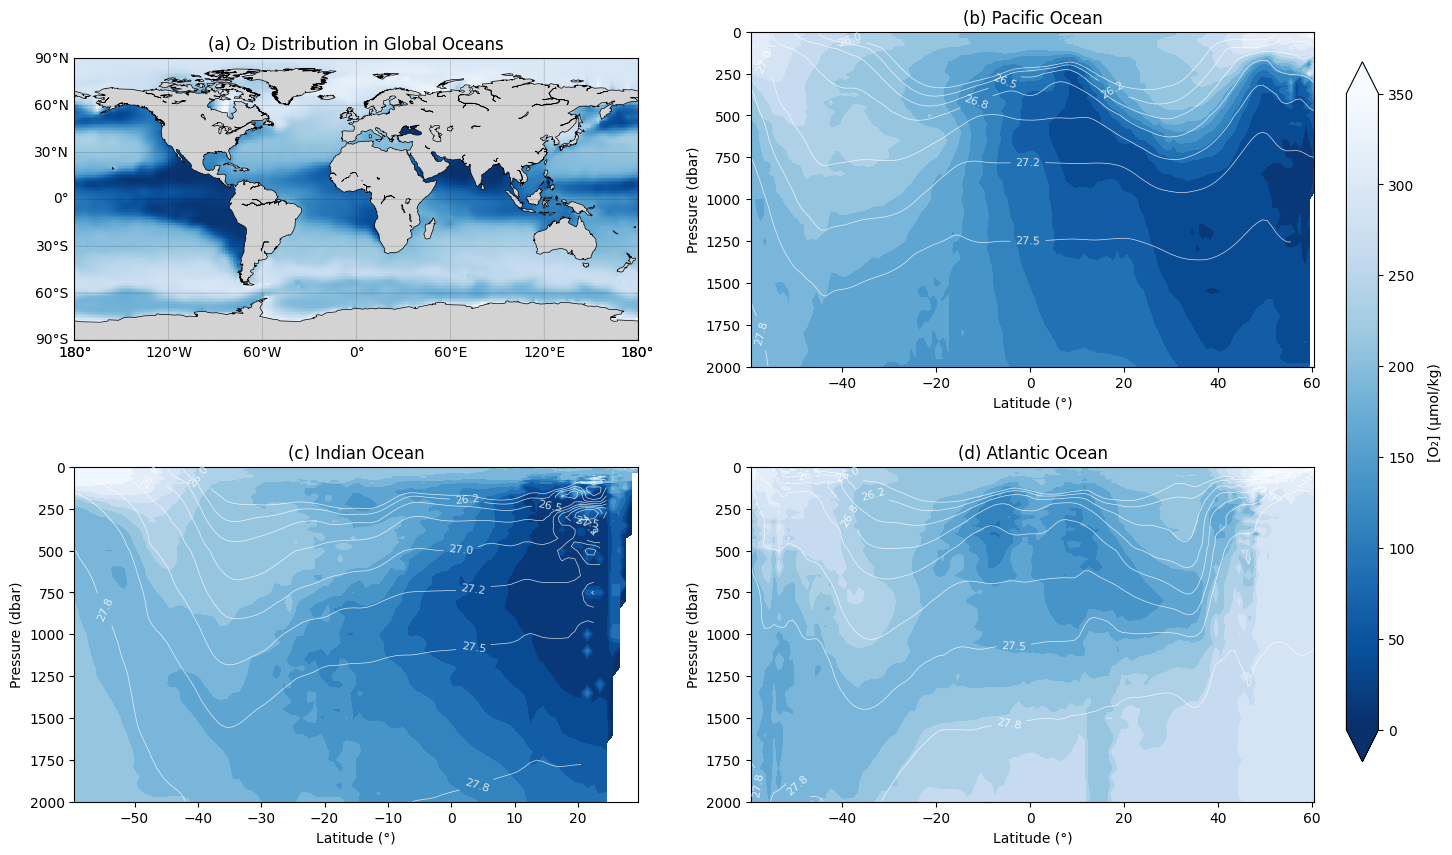

In [10]:
# Call the function to plot
fig = plot_ocean_sections(processed_data)
plt.show()
